# CIFAR-10

Что это? Это датасет, собранный в университете Торонто.

Содержит 60000 изображений размером 32x32, 10 классов, ровно по 6000 изображений в каждом. Подробнее можно почитать здесь:
* https://www.cs.toronto.edu/~kriz/cifar.html
* http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130

<img src="images/cifar_preview.png" width="50%">

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
import tensorflow as tf

# Assume that you have 12GB of GPU memory and want to allocate ~4GB:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
config = tf.ConfigProto(gpu_options=gpu_options)   
sess = tf.Session(config=config)

from keras.backend.tensorflow_backend import set_session
 
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
config = tf.ConfigProto(gpu_options=gpu_options)
init = tf.global_variables_initializer()
sess = tf.Session(config=config)
 
sess.run(init)
 
set_session(sess)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


---

In [3]:
from keras.datasets import cifar10

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

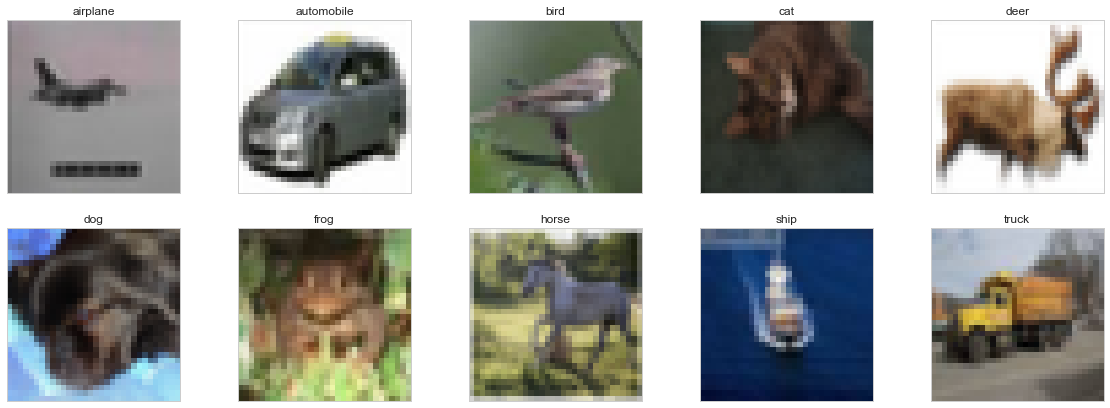

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig = plt.figure(figsize=(20,7))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

---

In [7]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [8]:
def prepare_cifar(X_train, X_test, y_train, y_test, val_fraction=0.1):
    # X
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255.0
    X_test /= 255.0
    
    # y
    l = len(y_train)
    y = to_categorical(np.vstack([y_train, y_test]))
    y_train_cat, y_test_cat = y[:l], y[l:]
    
    # val
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train_cat, test_size=val_fraction)
    
    return X_tr, X_val, y_tr, y_val, X_test, y_test_cat

In [9]:
X_tr, X_val, y_tr, y_val, X_test, y_test = prepare_cifar(X_train, X_test, y_train, y_test, val_fraction=0.1)

In [10]:
X_tr.shape, X_val.shape, X_test.shape, y_tr.shape, y_val.shape, y_test.shape

((45000, 32, 32, 3),
 (5000, 32, 32, 3),
 (10000, 32, 32, 3),
 (45000, 10),
 (5000, 10),
 (10000, 10))

Смотрите, что получилось:

In [11]:
y_tr[:3, :]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

Сразу сохраним в константы:

In [11]:
input_shape = (32, 32, 3)
n_classes = 10

batch_size = 128
epochs = 50

# Модели

## LeNet5

Первое успешное применение сверточных нейронных сетей в задаче распознавания изображений было продемонстрировано именно сетью LeNet-5. Она была разработана еще в 1990-ые Яном ЛеКуном и была использована для распознавания почтовых индексов и цифр. 

Можно посмотреть вот здесь: http://yann.lecun.com/exdb/lenet/

Основные характеристики LeNet-5:

* состояла из последовательностей трех слоев: сверточного, пулинг-слоя и слоя активации;
* входные значения пикселей были нормализованы путем масштабирования;
* использованы гиперболический тангенс или сигмода в качестве функций активации;
* использован обучаемый усредняющий пулинг как функция пулинга;
* несколько полносвязных слоев как финальный классификатор;
* функция потерь -- MSE.

In [14]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout

In [15]:
model = Sequential()
model.add(Convolution2D(12, (5, 5), padding="same", activation='tanh', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Convolution2D(8, (5, 5), padding="same", activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 12)        912       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 8)         2408      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total para

In [17]:
model.compile(optimizer='adam', 
              loss='mse',
              metrics=['accuracy'])

In [18]:
from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping

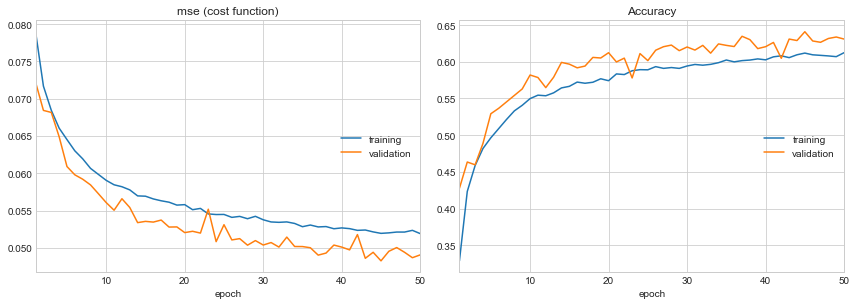

In [36]:
history = model.fit(X_tr, y_tr, validation_data=(X_val, y_val),
              batch_size=batch_size, epochs=epochs,
              verbose=0, callbacks=[
                  PlotLossesKeras(), 
#                   EarlyStopping(monitor='loss')
              ],
              shuffle=True)

In [37]:
model.save('lenet5')

In [38]:
def save_history(history, path):
    with open(path, 'wb') as f:
        pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

In [39]:
save_history(history, 'lenet5_history')

## AlexNet

AlexNet  исторически стала первой работой, которая популяризовала использование сверточных нейронных сетей в компьютерном зрении. Она была впервые показана в 2012 году на конкурсе по визуальному распознаванию ILSVRC и значительно оторвалась от конкурентов, работы которых сводились к использованию признаков изображений, сформированных вручную.

По сравнению с LeNet-5, AlexNet имела больше параметров (60 млн.) и была глубже (5 сверточных слоев, 3 слоя пулинга и 3 полносвязных слоя). На момент реализации авторы использовали фреймворк CUDA для параллелизации вычислений и обхода ограничений по памяти.

AlexNet популяризовал:

* ReLU для функцию активации;
* метод применения функций активации сразу после сверточного слоя, не допуская слою пулинга появиться между ними;
* метод $max$-пулинга с перекрытием.

В следующем году победителем ILSVRC стала сеть ZFNet, которая не внесла ничего принципиально нового. Она полностью базировалась на AlexNet, была еще больше своего предшественника (140 млн. параметров), а некоторые сверточные слои в середине сети были расширены. Также сдвиг и количество фильтров на первом слое были уменьшены.

In [40]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Convolution2D, MaxPooling2D, Activation

In [31]:
model = Sequential()
model.add(Convolution2D(64, kernel_size=(3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(192, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(256, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(200, kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Activation('softmax'))

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 128)       0         
__________

In [33]:
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

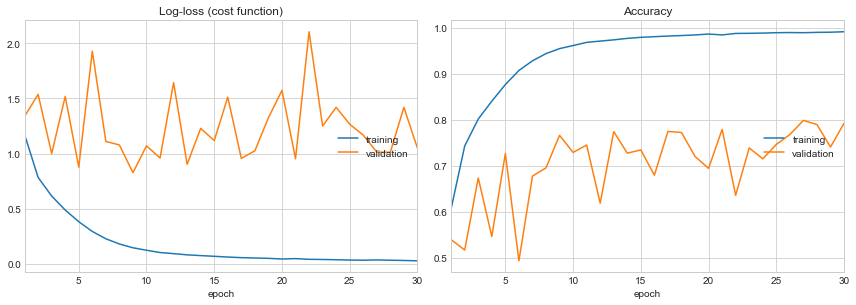

In [34]:
history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              verbose=0,
              callbacks=[PlotLossesKeras()],
              shuffle=True);

In [35]:
model.save('alexnet')

In [37]:
save_history(history, 'alexnet_history')

## VGG

VeryDeep, или VggNet -- нейронная сеть, показавшая значимый результат в рамках ILSVRC 2014 г. Исследователями было показано, что глубина -- критически важный компонент архитектуры сверточной нейронной сети для достижения хороших результатов. Они использовали ядра меньшего размера ($3\times 3$) в каждом из сверточных слоев, а также объединяли в последовательности сверточных слоев. 

Авторы показали, что несколько выстроенных подряд сверток $3 \times 3$ могут обеспечить тот же эффект, что и более широкие рецептивные поля, будь то $5\times 5$ или $7 \times 7$.


<img src='images/vgg_block.png' width='40%'>

In [19]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

In [20]:
img_input = Input(shape=input_shape)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(200, activation='relu')(x)
x = Dense(n_classes, activation='softmax')(x)
model = Model(img_input, x, name='vgg16')

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [22]:
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

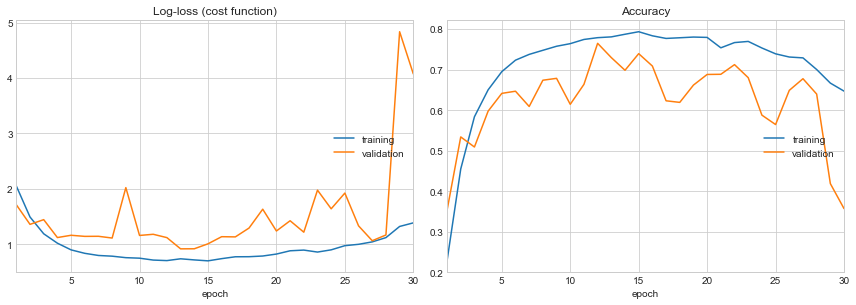

In [23]:
history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              verbose=0,
              callbacks=[PlotLossesKeras()],
              shuffle=True);

In [24]:
model.save('vgg')

In [25]:
save_history(history, 'vgg_history')

---

# Как _должно_ идти обучение?

In [49]:
input_shape = (32, 32, 3)
n_classes = 10

batch_size = 64
epochs = 50

In [50]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten

In [51]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [52]:
from keras.optimizers import rmsprop

In [53]:
opt = rmsprop(lr=0.0001, decay=1e-6)

In [54]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
__________

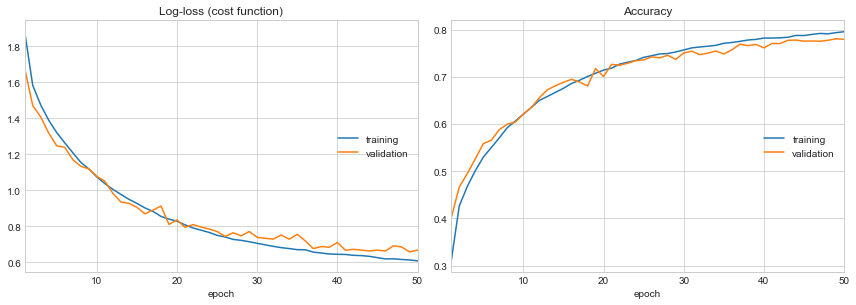

In [56]:
history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              verbose=0,
              callbacks=[PlotLossesKeras()],
              shuffle=True);

<img src='images/just_right.png' width='30%'>

In [59]:
model.save('just_right')
save_history(history, 'just_right_history')